In [1]:
import csv
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
from scipy import ndimage

import matplotlib
from matplotlib.pyplot import figure
#import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator

In [2]:
objects = ['neighborhoods',
           'census_income_data',
           'ids',
           'date',
           'ptype',
           'category',
           'location',
           'arrest',
           'community_area',
           'geometry',
           'crime_data',
           'crimes']

for thing in objects:
    try:
        del thing
    except NameError as e:
        print("Couldn't delete {0}".format(thing))
        print(e)
        continue


In [3]:
neighborhoods = gpd.read_file('community-areas.geojson')
census_income_data = gpd.read_file('census-tracts-2000.geojson')

In [4]:
def getx(pt):
    return pt.coords[0][0]

def gety(pt):
    return pt.coords[0][1]

In [5]:
ids = []
date = []
ptype = []
category = []
#desc = []
location = []
arrest = []
community_area = []
geometry = []

In [6]:
categories: dict = {"THEFT": "property",
                    "BURGLARY": "property",
                    "MOTOR VEHICLE THEFT": "property",
                    "ARSON": "property",
                    "CRIMINAL DAMAGE": "property",
                    "ROBBERY": "property",
                    "ASSAULT": "person",
                    "BATTERY": "person",
                    "CRIM SEXUAL ASSAULT": "person",
                    "HOMICIDE": "person",
                    "INTIMIDATION": "person",
                    "KIDNAPPING": "person",
                    "OFFENSE INVOLVING CHILDREN": "person",
                    "SEX OFFENSE": "person",
                    "STALKING": "person",
                    "GAMBLING": "vice",
                    "NARCOTICS": "vice",
                    "PROSTITUTION": "vice",
                    "LIQUOR LAW VIOLATION": "vice",
                    "OBSCENITY": "vice",
                    "OTHER NARCOTIC VIOLATION": "vice",
                    "PUBLIC INDECENCY": "vice",
                    "OTHER OFFENSE": "other",
                    "DECEPTIVE PRACTICE": "other",
                    "WEAPONS VIOLATION": "other",
                    "PUBLIC PEACE VIOLATION": "other",
                    "CRIMINAL TRESPASS": "other",
                    "INTERFERENCE WITH PUBLIC OFFICER": "other",
                    "NON-CRIMINAL": "other"
                   }

In [7]:
chunkfiles: list = ['crimes-2010-2011-0.csv', 'crimes-2010-2011-1.csv']

min_lat = 45.
max_lat = 41.
min_lon = -91.
max_lon = -91.

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        crimereader = csv.reader(crimes_fh)
        for row in crimereader:
            try:
                lat = float(row[19])
                if lat == 36.619446395:
                    continue
                lon = float(row[20])
                if lat < min_lat:
                    min_lat = lat
                    #print("Min lat found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lat > max_lat:
                    max_lat = lat
                    #print("Max lat found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lon < min_lon:
                    min_lon = lon
                    #print("Min lon found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lon > max_lon:
                    max_lon = lon
                    #print("Max lon found[{0}]: {1}x{2}".format(row[0], lat, lon))
            except Exception as e:
                continue
            ids.append(row[0])
            date.append(row[2].split(" ")[0])
            ptype.append(row[5])
            category.append(categories[row[5]])
            location.append(row[7])
            arrest.append(row[8])
            community_area.append(row[9])
            geometry.append(shapely.geometry.point.Point(lon, lat))

Min lat found[8265244]: 41.95396528x-87.771918163
Max lat found[8265244]: 41.95396528x-87.771918163
Max lon found[8265244]: 41.95396528x-87.771918163
Max lat found[4991465]: 42.001678618x-87.660604177
Max lon found[4991465]: 42.001678618x-87.660604177
Min lat found[5147738]: 41.802219519x-87.663439163
Max lon found[5281401]: 41.802238398x-87.613918511
Min lat found[11020229]: 41.701867053x-87.530451675
Max lon found[11020229]: 41.701867053x-87.530451675
Max lat found[7291823]: 42.00676766x-87.673597598
Min lat found[7331615]: 41.700687359x-87.619500705
Max lat found[7602316]: 42.011970273x-87.688015969
Min lat found[7871698]: 41.677507979x-87.663130735
Min lat found[8371884]: 41.649491211x-87.53989848
Max lat found[7610940]: 42.017691576x-87.673002618
Max lat found[7611932]: 42.020009355x-87.669489875
Max lon found[7616725]: 41.702034731x-87.526963434
Min lat found[7617540]: 41.645835887x-87.614600077
Max lat found[7622324]: 42.02152431x-87.6718957
Max lat found[7626378]: 42.021675231x

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        crimereader = csv.reader(fh)
        for row in crimereader:
            if "IUCR" in row or '"(41' not in row:
                # Ignore the header row and rows missing GPS coordinates
                continue
            else:
                row = row.replace(',,',',<empty>,').replace(')"','').rstrip()
                row = row.lstrip('"(')
                fields = row.split(',')
                ids.append(fields[0])
                date.append(fields[2].split(' ')[0])
                ptype.append(fields[5])
                desc.append(fields[6])
                locdesc.append(fields[7])
                arrest.append(fields[8])
                community_area.append(fields[9])
                lat = float(fields[-3].lstrip('"('))
                lon = float(fields[-4].rstrip(')"'))
                geometry.append(shapely.geometry.point.Point(lat, lon))

In [9]:
crime_data = {
        'date': pd.Series(date, index=ids),
        "primary type": pd.Series(ptype, index=ids, dtype="category"),
        "category": pd.Series(category, index=ids, dtype="category"),
        "location description": pd.Series(location, index=ids),
        "arrest": pd.Series(arrest, index=ids),
        "community area": pd.Series(community_area, index=ids),
        "geometry": pd.Series(geometry, index=ids)
        }

In [10]:
crimes = gpd.GeoDataFrame(crime_data, index=ids)

In [11]:
print(crimes.info())
print(crimes['primary type'].unique())
print(crimes['category'].unique())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 721337 entries, 8265244 to 8198043
Data columns (total 7 columns):
date                    721337 non-null object
primary type            721337 non-null category
category                721337 non-null category
location description    721337 non-null object
arrest                  721337 non-null object
community area          721337 non-null object
geometry                721337 non-null object
dtypes: category(2), object(5)
memory usage: 34.4+ MB
None
[BURGLARY, DECEPTIVE PRACTICE, OFFENSE INVOLVING CHILDREN, OTHER OFFENSE, CRIM SEXUAL ASSAULT, ..., OBSCENITY, OTHER NARCOTIC VIOLATION, PUBLIC INDECENCY, HOMICIDE, NON-CRIMINAL]
Length: 29
Categories (29, object): [BURGLARY, DECEPTIVE PRACTICE, OFFENSE INVOLVING CHILDREN, OTHER OFFENSE, ..., OTHER NARCOTIC VIOLATION, PUBLIC INDECENCY, HOMICIDE, NON-CRIMINAL]
[property, other, person, vice]
Categories (4, object): [property, other, person, vice]


x = list(crimes.geometry.apply(getx))
y = list(crimes.geometry.apply(gety))
heatmap, xedges, yedges = np.histogram2d(y, x, bins=(100, 100))
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, 1, mode='nearest')

In [15]:
with open("sorted-census-tract-median-household-income.csv", "r") as tract_income:
    tract_income_list = list(csv.DictReader(tract_income))

In [16]:
tract_info_df = pd.DataFrame(tract_income_list)
with_incomes = pd.merge(census_income_data, tract_info_df, on="census_tra")

In [23]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    return logheatmap
    #plt.imshow(logheatmap, cmap=cmap, extent=extent)
    #plt.colorbar()
    #plt.gca().invert_yaxis()
    #plt.show()

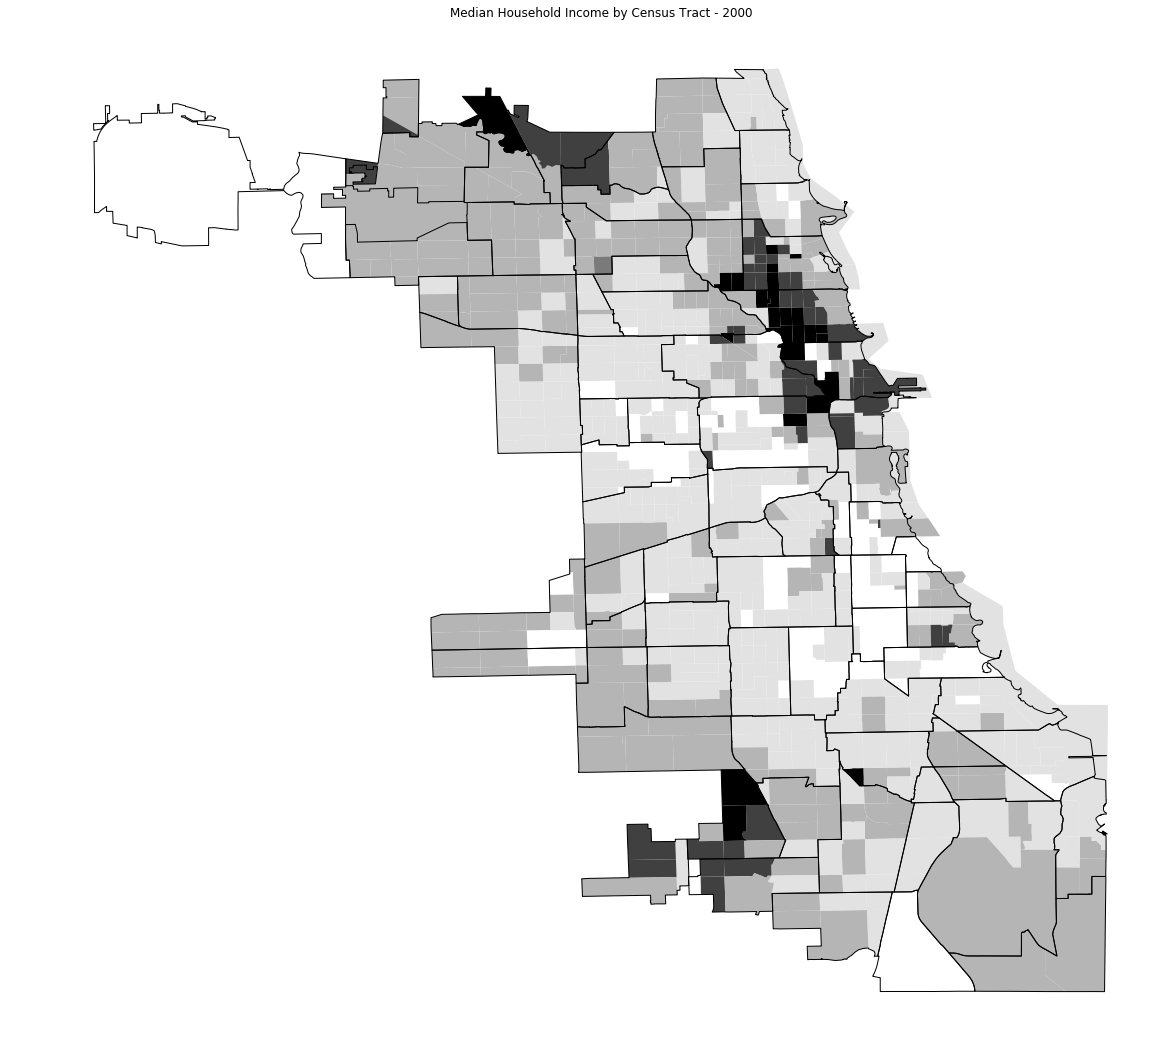

In [53]:
fig, ax = plt.subplots(figsize=(20, 20))

income_ranges = np.array(["",
                          "$0      - $20,000",
                          "$20,001 - $40,000",
                          "$40,001 - $60,000",
                          "$60,001 - $80,000",
                          "$80,001 +"
                         ])

ax.set_aspect('equal')
ax.axis('off')
    
#cMap = ListedColormap(["#333333", "#555555", "#999999", "#BBBBBB", "#EEEEEE"])
cMap = plt.get_cmap('Greys')
levels = np.linspace(0, 5, 6, dtype=int)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cMap.N, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: income_ranges[::-1][norm(x)])
#wi_plot = with_incomes.plot(ax=ax, column="income_range",  cmap=cMap, legend=True)
#cb1 = matplotlib.colorbar.ColorbarBase(cmap="Greys",
#                                       norm=norm,
#                                       orientation='horizontal', ax=ax)

ax.set_title('Median Household Income by Census Tract - 2000')
with_incomes.plot(ax=ax, column="income_range",  cmap=cMap)
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

#plt.show()
plt.savefig('census-mhi.png', bbox_inches='tight')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


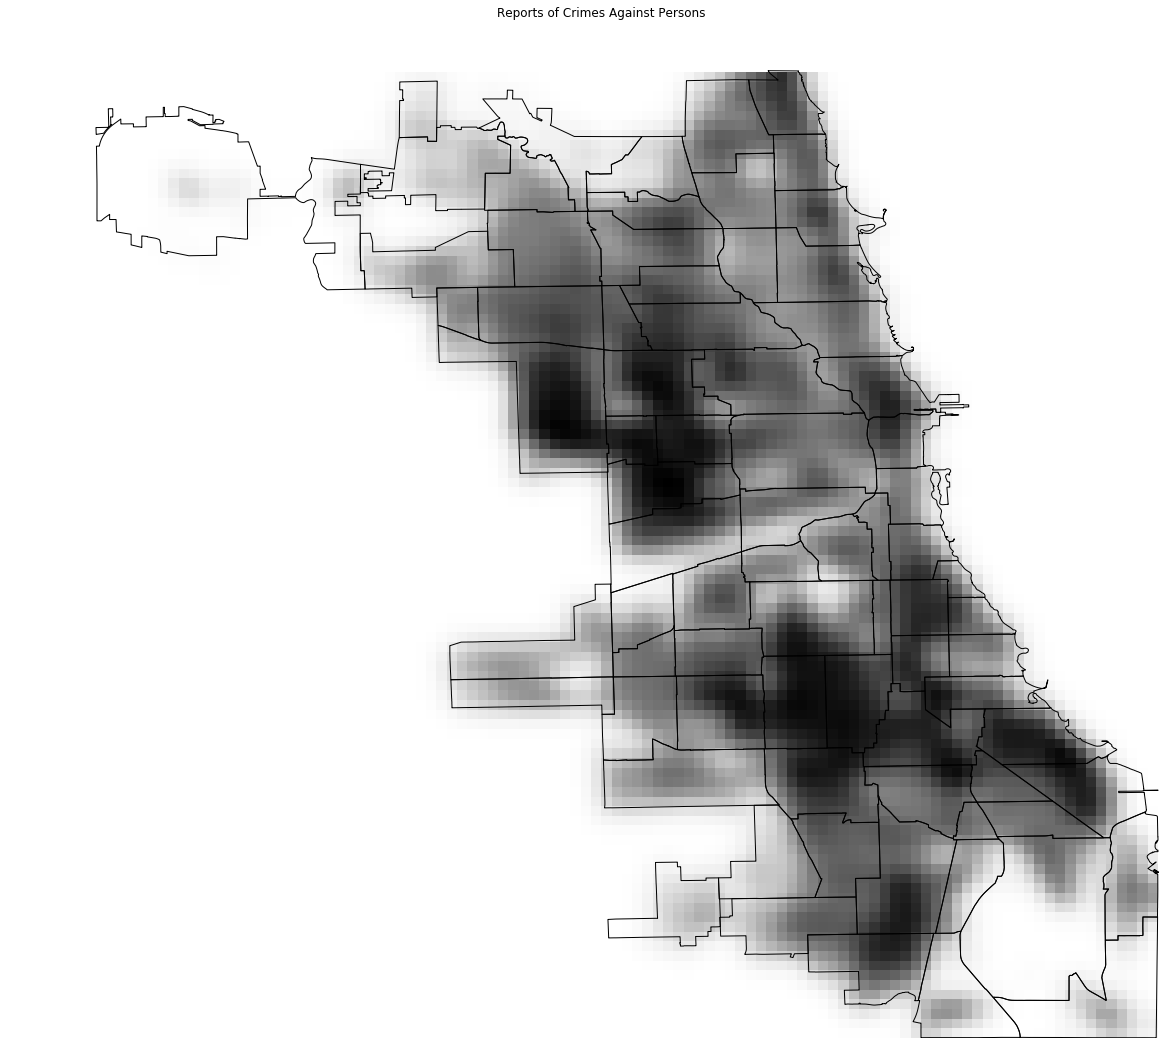

In [54]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Crimes Against Persons')
ax.set_aspect('equal')
ax.axis('off')
plt.imshow(heatmap(crimes.loc[lambda crimes: crimes['category'] == 'person', :],
                   bins=(100, 100), smoothing=1.3, cmap=cMap),
           cmap=cMap, extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
#plt.show()
plt.savefig('police-reports-person.png', bbox_inches='tight')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


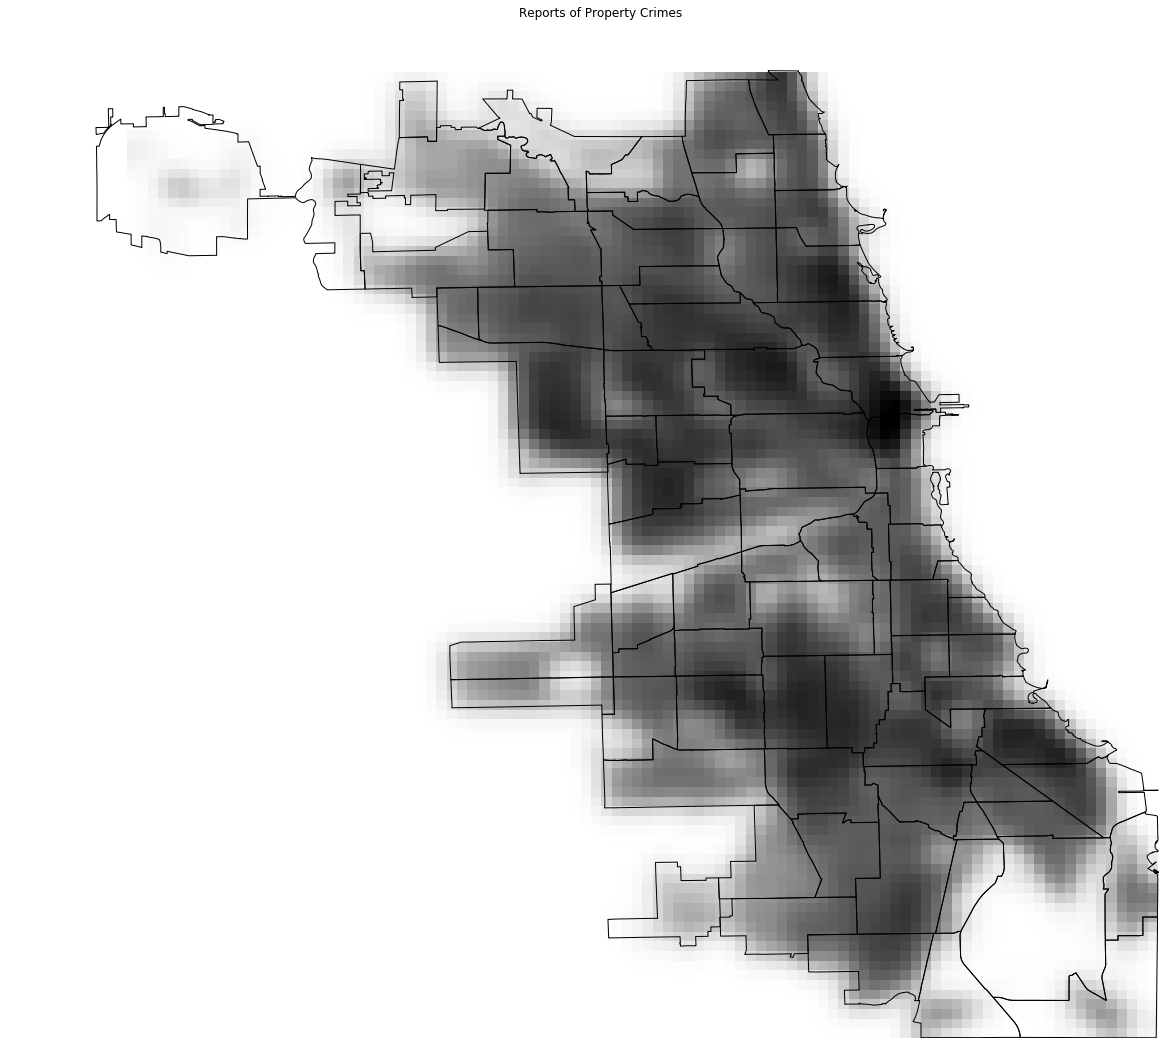

In [55]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Property Crimes')
ax.set_aspect('equal')
ax.axis('off')
plt.imshow(heatmap(crimes.loc[lambda crimes: crimes['category'] == 'property', :],
                   bins=(100, 100), smoothing=1.3, cmap=cMap),
           cmap=cMap, extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
#plt.show()
plt.savefig('police-reports-property.png', bbox_inches='tight')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


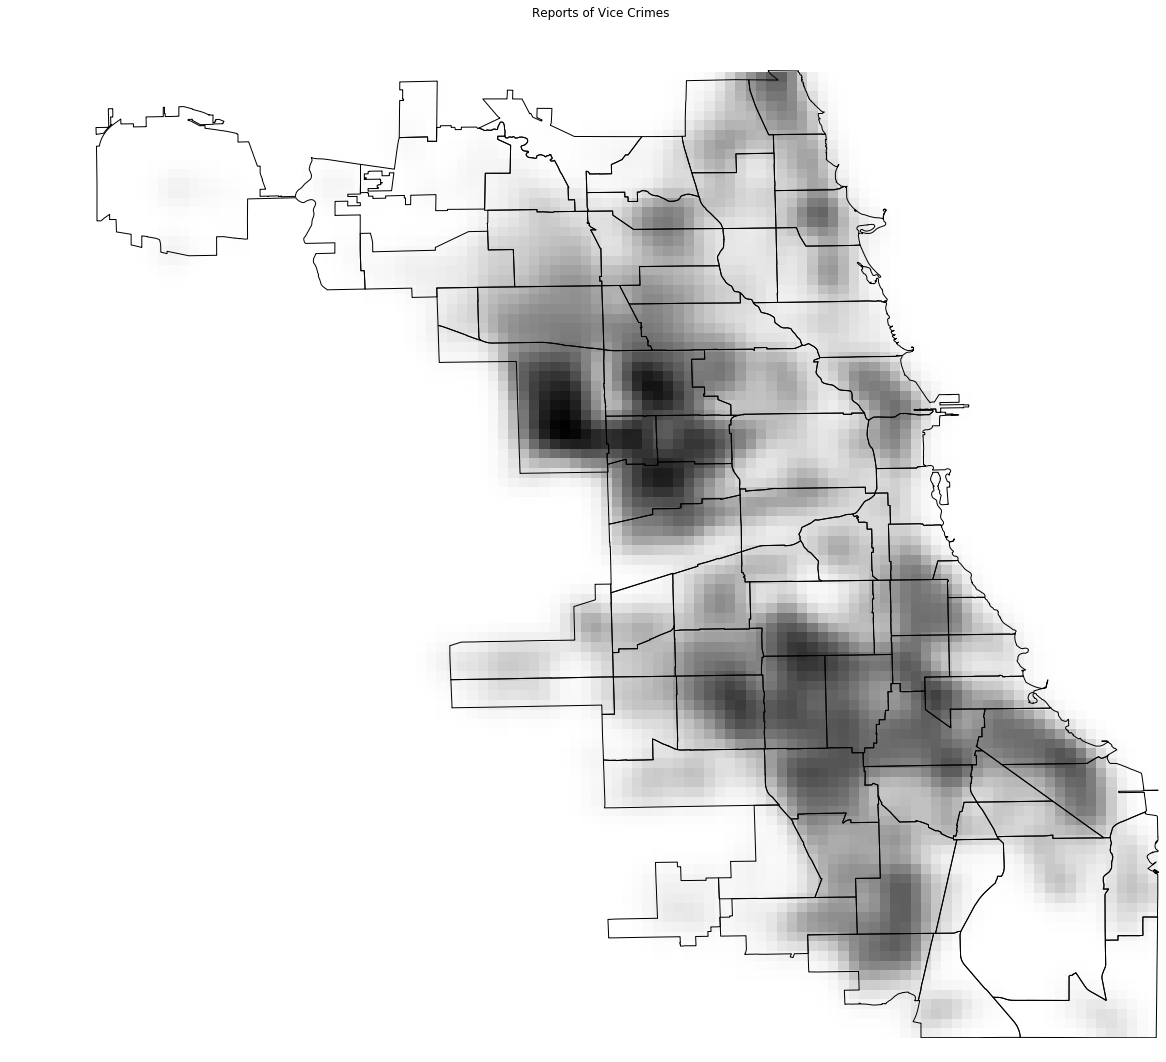

In [56]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Vice Crimes')
ax.set_aspect('equal')
ax.axis('off')
plt.imshow(heatmap(crimes.loc[lambda crimes: crimes['category'] == 'vice', :],
                   bins=(100, 100), smoothing=1.3, cmap=cMap),
           cmap=cMap, extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
#plt.show()
plt.savefig('police-reports-vice.png', bbox_inches='tight')

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


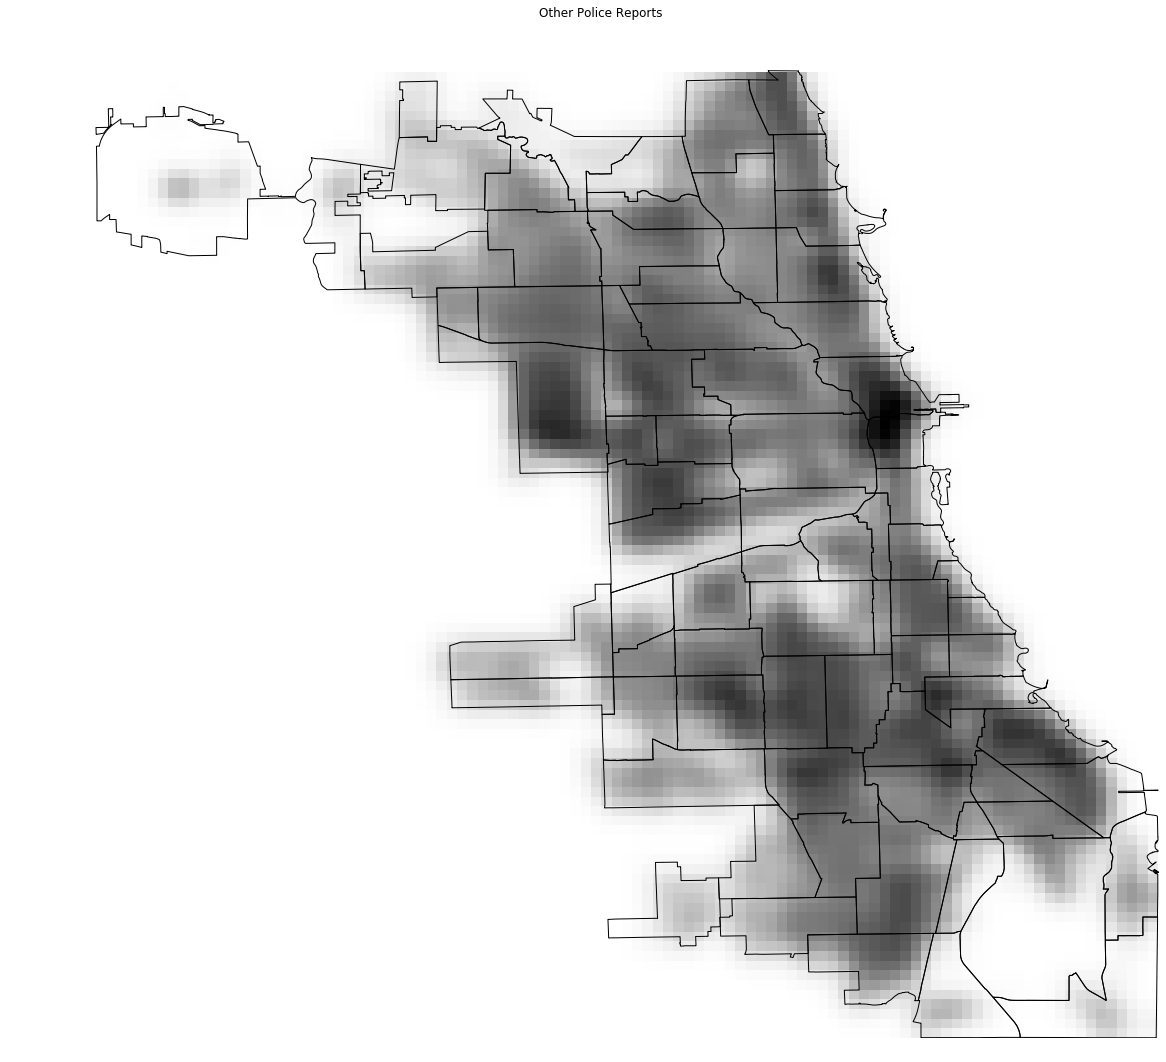

In [57]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Other Police Reports')
ax.set_aspect('equal')
ax.axis('off')
plt.imshow(heatmap(crimes.loc[lambda crimes: crimes['category'] == 'other', :],
                   bins=(100, 100), smoothing=1.3, cmap=cMap),
           cmap=cMap, extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
#plt.show()
plt.savefig('police-reports-other.png', bbox_inches='tight')

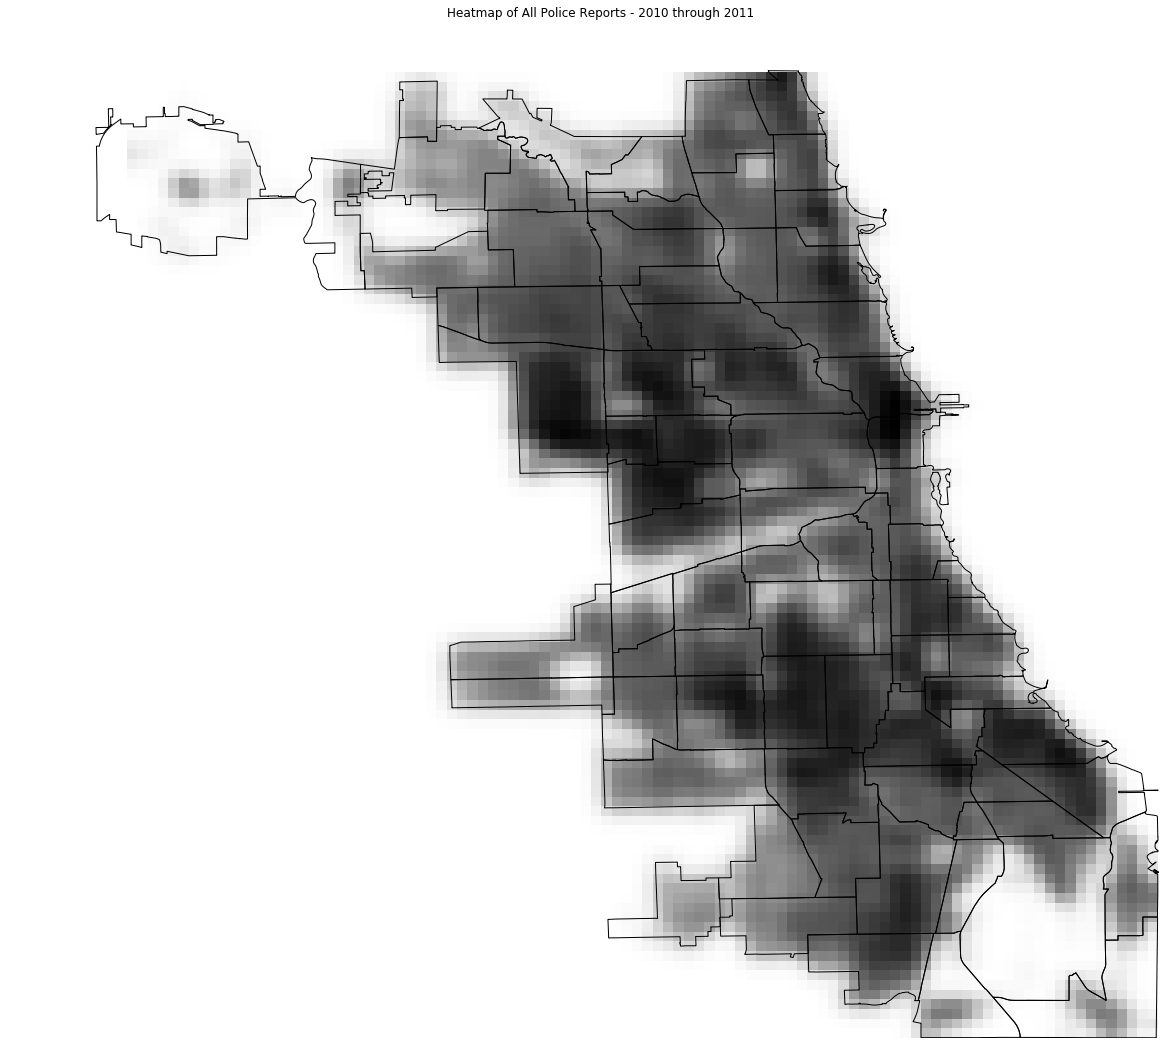

In [59]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')
ax.set_title('Heatmap of All Police Reports - 2010 through 2011')
ax.axis("off")
plt.imshow(logheatmap, cmap=cMap, extent=extent)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')
#plt.show()
plt.savefig('police-reports-all.png', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(20, 20))

income_ranges = np.array(["",
                          "$0      - $20,000",
                          "$20,001 - $40,000",
                          "$40,001 - $60,000",
                          "$60,001 - $80,000",
                          "$80,001 +"
                         ])

ax.set_aspect('equal')
ax.axis('off')

ax.set_title('Median Household Income by Census Tract - 2000')

#cMap = ListedColormap(["#333333", "#555555", "#999999", "#BBBBBB", "#EEEEEE"])
cMap = plt.get_cmap('Greys')

levels = np.linspace(0, 5, 6, dtype=int)

norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cMap.N, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: income_ranges[::-1][norm(x)])

with_incomes.plot(ax=ax, column="income_range",  cmap=cMap)
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

#plt.show()
plt.savefig('police-reports-other.png', bbox_inches='tight')

#cb1 = matplotlib.colorbar.ColorbarBase(cmap="Greys",
#                                       norm=norm,
#                                       orientation='horizontal', ax=ax)
#cb1.set_label(income_ranges, fontsize=6)

cb1.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(income_ranges):
    cb1.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='bottom')
cb1.ax.get_yaxis().labelpad = 15
cb1.ax.set_ylabel('Income Ranges') #, rotation=270)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(with_incomes.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(with_incomes.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

plt.tight_layout()


#bounds = np.linspace(0,6,5)
#cb = plt.colorbar(wi_plot, spacing='proportional', ticks=bounds)
#cb = plt.colorbar(ax=ax, spacing='proportional', ticks=bounds)
#cb.set_label('Custom cbar')
#ax.set_title('Discrete color mappings')


#plt.colorbar(ax=ax, format=fmt)

# add the colorbar to the figure
#cbar = fig.colorbar(sm, ax=ax)

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        for row in crimes_fh:
            if "IUCR" in row or '"(41' not in row:
                # Ignore the header row and rows missing GPS coordinates
                continue
            else:
                row = row.replace(',,',',<empty>,').replace(')"','').rstrip()
                row = row.lstrip('"(')
                fields = row.split(',')
                ids.append(fields[0])
                date.append(fields[2].split(' ')[0])
                ptype.append(fields[5])
                desc.append(fields[6])
                locdesc.append(fields[7])
                arrest.append(fields[8])
                community_area.append(fields[9])
                lat = float(fields[-3].lstrip('"('))
                lon = float(fields[-4].rstrip(')"'))
                geometry.append(shapely.geometry.point.Point(lat, lon))

data = {
        'date': pd.Series(date, index=ids),
        "primary type": pd.Series(ptype, index=ids),
        "description": pd.Series(desc, index=ids),
        "location description": pd.Series(locdesc, index=ids),
        "arrest": pd.Series(arrest, index=ids),
        "community area": pd.Series(community_area, index=ids),
        "geometry": pd.Series(geometry, index=ids)
        }

with open("Crimes-2010-2011.csv", "r") as fh:
    crimereader = csv.reader(fh)
    for row in crimereader:
        try:
            lat = float(row[19])
            lon = float(row[20])
        except Exception as e:
            continue
        ids.append(row[0])
        date.append(row[2].split(" ")[0])
        ptype.append(row[5])
        category.append(categories[row[5]])
        location.append(row[7])
        arrest.append(row[8])
        community_area.append(row[9])
        geometry.append(shapely.geometry.point.Point(lat, lon))